# Проверка гипотез о выручке проката самокатов

Нужно изучить модели монетизации сервиса аренды электросамокатов по подписке и без подписки.

## Цель
Сформулировать полезные для повышения выручки выводы.

## Описание данных:
### Пользователь
- `user_id` — уникальный идентификатор пользователя
- `name` — имя пользователя
- `age` — возраст
- `city`— город
- `subscription_type` — тип подписки (free, ultra)
### Поездки 
- `user_id` — уникальный идентификатор пользователя
- `distance` — расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration` — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- `date` — дата совершения поездки
### Подписки
- `subscription_type` — тип подписки
- `minute_price` — стоимость одной минуты поездки по данной подписке
- `start_ride_price` — стоимость начала поездки
- `subscription_fee` — стоимость ежемесячного платежа

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime as dt
import math
from scipy import stats as st

## Подготовка данных

### Откроем файлы с данными и изучим общую информацию

In [7]:
try:
    users = pd.read_csv(r".\source\users_go.csv")
    rides = pd.read_csv(r".\source\rides_go.csv")
    subscriptions = pd.read_csv(r".\source\subscriptions_go.csv")
except:
    users = pd.read_csv("/datasets/users_go.csv")
    rides = pd.read_csv("/datasets/rides_go.csv")
    subscriptions = pd.read_csv("/datasets/subscriptions_go.csv")

pd.set_option('display.max_columns', None)
print(f"Users:\n{users  .head(20)}")
print(f"Rides:\n{rides.head(20)}")
print(f"Subscriptions:\n{subscriptions.head(20)}")

Users:
    user_id        name  age            city subscription_type
0         1        Кира   22          Тюмень             ultra
1         2   Станислав   31            Омск             ultra
2         3     Алексей   20          Москва             ultra
3         4  Константин   26  Ростов-на-Дону             ultra
4         5       Адель   28            Омск             ultra
5         6      Регина   25       Краснодар             ultra
6         7       Игорь   23            Омск             ultra
7         8        Юрий   23       Краснодар             ultra
8         9          Ян   21       Пятигорск             ultra
9        10     Валерий   18    Екатеринбург             ultra
10       11       Агата   31       Краснодар             ultra
11       12        Марк   27          Тюмень             ultra
12       13         Ева   24       Краснодар             ultra
13       14    Антонина   18       Пятигорск             ultra
14       15     Валерия   24          Тюмень    

Преобразуем колонки к соответствующим типам данных.

In [8]:
def print_info():
    users.info()
    rides.info()
    subscriptions.info()

print_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Col

Приведём date в таблице поездок к типу даты.

In [9]:
rides = rides.astype({"date" : "datetime64[ns]"})
print_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries

Создадим столбец с номером месяца для удобства.

In [10]:
rides["month_number"] = rides["date"].dt.month

### Обработаем пропуски

In [11]:
# check
# пропущенные значения бары

def pass_value_barh(dfg, title):
    try:
        (
            (dfg.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (10,10), legend = False, fontsize = 16, grid=True, xlabel="Процент записей с пропусками")
            .set_title(title)
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции')

пропусков не осталось :) или произошла ошибка в первой части функции


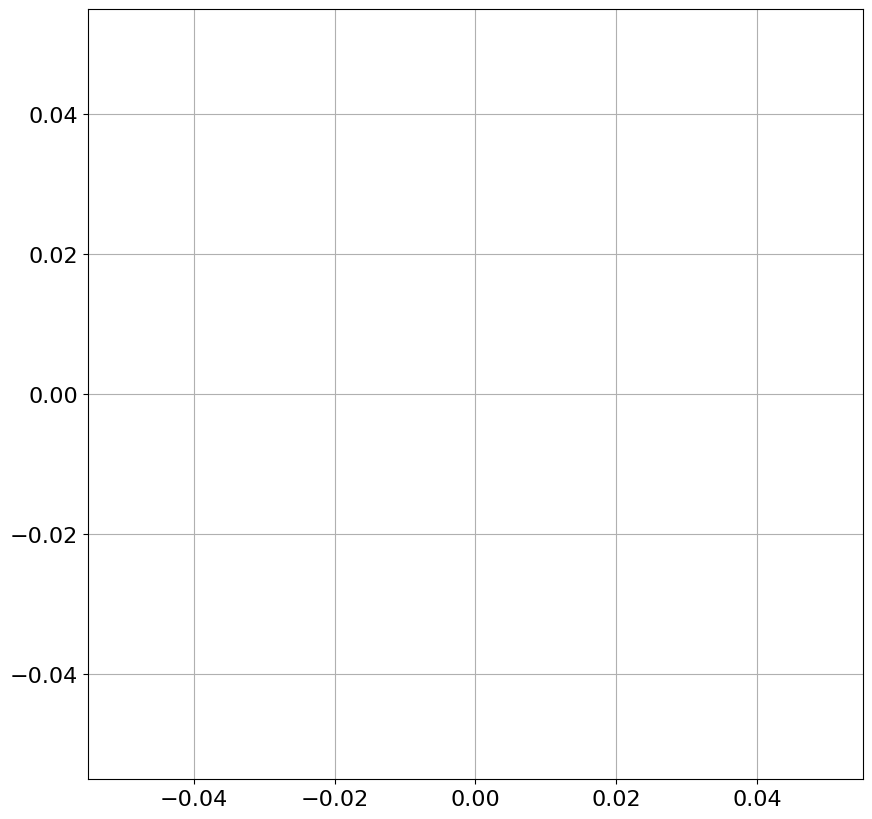

In [12]:
pass_value_barh(users, "Количество пропусков в пользователях")

пропусков не осталось :) или произошла ошибка в первой части функции


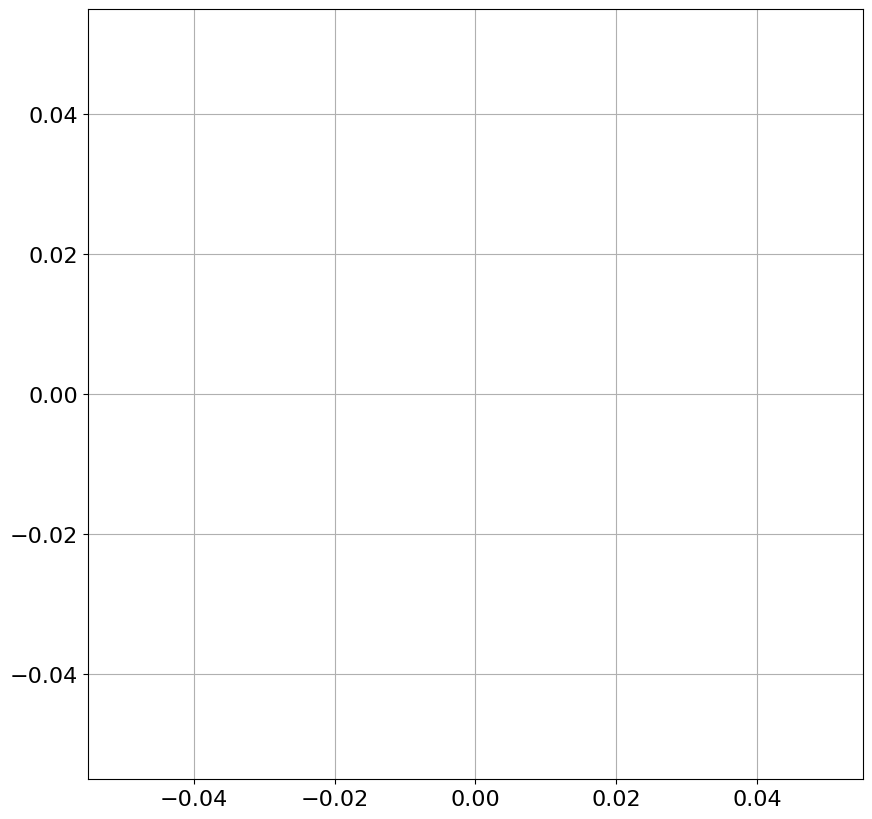

In [13]:
pass_value_barh(rides, "Количество пропусков в поездках")

пропусков не осталось :) или произошла ошибка в первой части функции


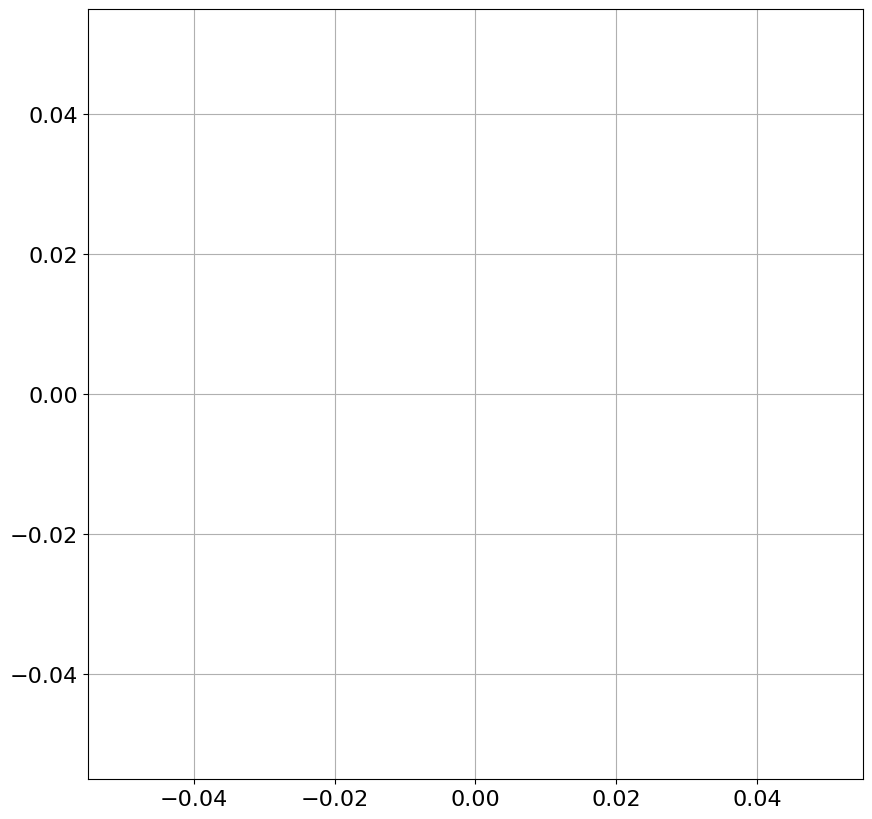

In [14]:
pass_value_barh(subscriptions, "Количество пропусков в подписках")

### Обработаем дубликаты

Проверим наличие явных дубликатов.

In [15]:
users.duplicated().sum()

31

Удалим явные убликаты для пользователей и обновим индекс.

In [16]:
users.drop_duplicates()


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
...,...,...,...,...,...
1529,1530,Ростислав,29,Сочи,free
1530,1531,Никита,25,Пятигорск,free
1531,1532,Алексей,26,Тюмень,free
1532,1533,Степан,22,Краснодар,free


In [17]:
users = users.reset_index(drop=True)

In [18]:
rides.duplicated().sum()

0

In [19]:
subscriptions.duplicated().sum()

0

## EDA

### Ознакомимся с пользователями.

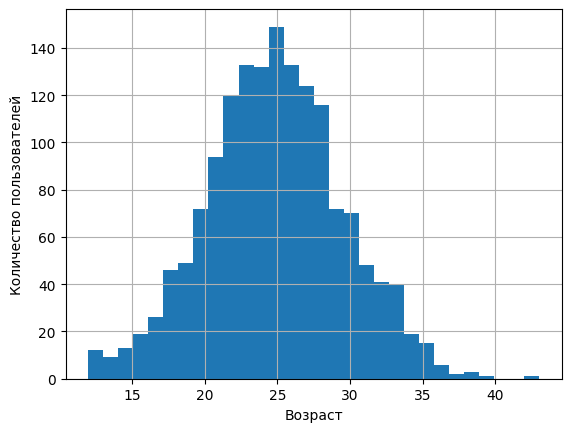

In [20]:
users["age"].hist(bins=30)
plt.xlabel("Возраст")
plt.ylabel("Количество пользователей")
plt.show()

Чаще всего арендой электросамокатов пользуется молодёжь от 20 до 30 лет. 25 лет — самый популярный возраст.

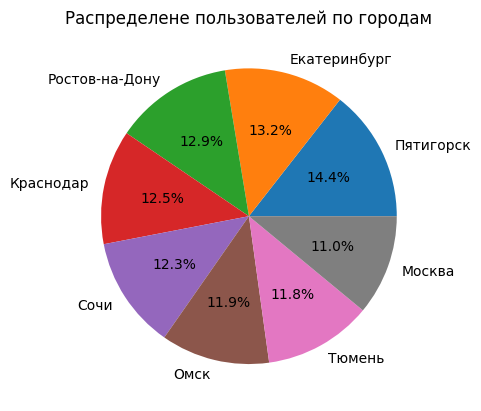

In [21]:
distribution = users["city"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Распределене пользователей по городам")
plt.show()

Пользователи распределены по городам относительно "равномерно".

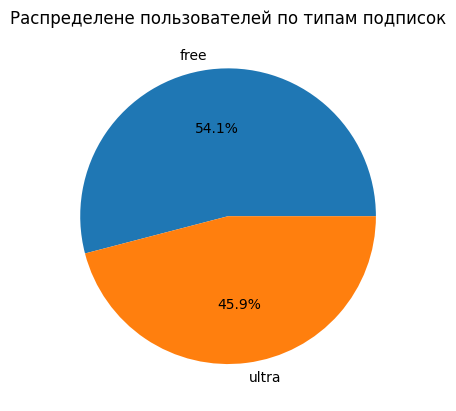

In [22]:
distribution = users["subscription_type"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Распределене пользователей по типам подписок")
plt.show()

Немного больше, около 10% разницы, пользователей, которые пользуются сервисом аренды без подписки.

### Ознакомимся с поездками

Рассмотрим расстояние, которое пользователи проезжают за одну поездку.

In [23]:
def rides_frequencies(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.hist(df["distance"], bins=30)
    ax1.set_title('Частота расстояния поездки')
    ax1.set_xlabel("Расстояние в метрах")
    ax1.set_ylabel("Количество пользователей")

    ax2.hist(df["duration"], bins=30)
    ax2.set_title('Частота длительности поездки')
    ax2.set_xlabel("Продолжительность в минутах")
    ax2.set_ylabel("Количество пользователей")

    plt.tight_layout()
    plt.show()

Рассмотрим продолжительность поездок по времени и расстоянию.

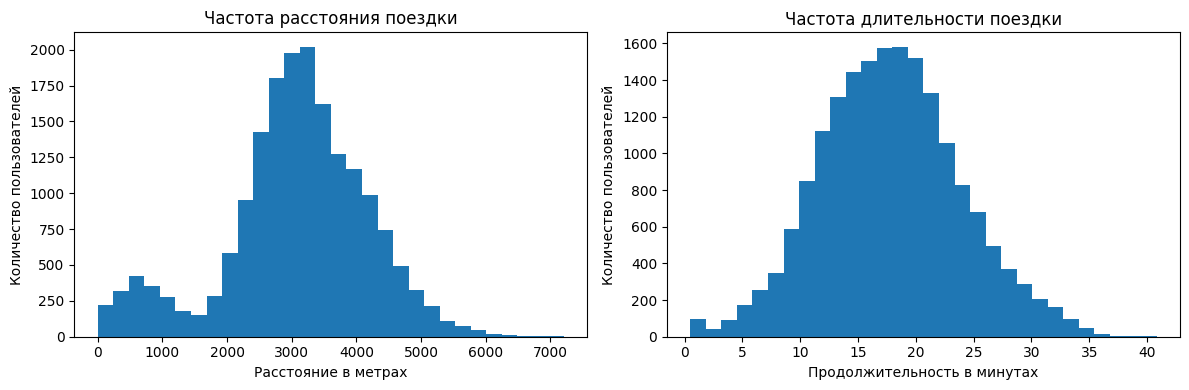

In [24]:
rides_frequencies(rides)

Обратим внимание, что график частот расстояния поездок мультимодальный. Пользователи проезжают либо около 600 метров, либо значительно больше, около 3100 метров.

График частот времени поездок тоже мультимодальный. Пользователи едут либо около 1 минуты, либо значительно больше, около 19 минут. При этом заметно, что дисперсия графика по продолжительности поездки выше, чем по расстоянию.

### Объединим части данных

In [25]:
df = rides.merge(users, on='user_id', how='left').merge(subscriptions, on='subscription_type', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18388 entries, 0 to 18387
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18388 non-null  int64         
 1   distance           18388 non-null  float64       
 2   duration           18388 non-null  float64       
 3   date               18388 non-null  datetime64[ns]
 4   month_number       18388 non-null  int64         
 5   name               18388 non-null  object        
 6   age                18388 non-null  int64         
 7   city               18388 non-null  object        
 8   subscription_type  18388 non-null  object        
 9   minute_price       18388 non-null  int64         
 10  start_ride_price   18388 non-null  int64         
 11  subscription_fee   18388 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Добавим два датафрейма с пользователями у которых есть и отсутствует подписка для удобства. 

In [26]:
subscribed = df[df["subscription_type"] == "ultra"].reset_index(drop=True)
subscribed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6672 entries, 0 to 6671
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6672 non-null   int64         
 1   distance           6672 non-null   float64       
 2   duration           6672 non-null   float64       
 3   date               6672 non-null   datetime64[ns]
 4   month_number       6672 non-null   int64         
 5   name               6672 non-null   object        
 6   age                6672 non-null   int64         
 7   city               6672 non-null   object        
 8   subscription_type  6672 non-null   object        
 9   minute_price       6672 non-null   int64         
 10  start_ride_price   6672 non-null   int64         
 11  subscription_fee   6672 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 625.6+ KB


In [27]:
unsubscribed = df.loc[df.index.difference(subscribed.index)].reset_index(drop=True)
unsubscribed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11716 entries, 0 to 11715
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11716 non-null  int64         
 1   distance           11716 non-null  float64       
 2   duration           11716 non-null  float64       
 3   date               11716 non-null  datetime64[ns]
 4   month_number       11716 non-null  int64         
 5   name               11716 non-null  object        
 6   age                11716 non-null  int64         
 7   city               11716 non-null  object        
 8   subscription_type  11716 non-null  object        
 9   minute_price       11716 non-null  int64         
 10  start_ride_price   11716 non-null  int64         
 11  subscription_fee   11716 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.1+ MB


### Изучим, какие частоты у расстояния поездок и времени поездок для пользователей с подписками и без

Пользователи с подпиской


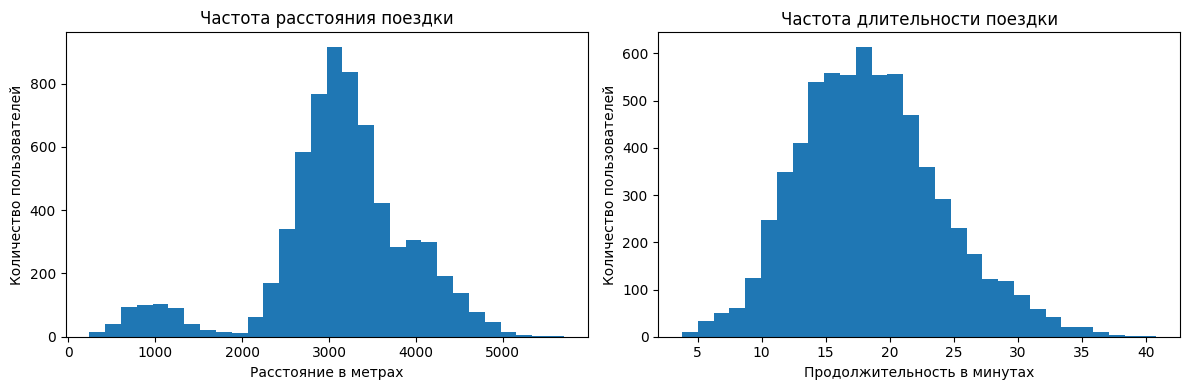

In [28]:
print("Пользователи с подпиской")
rides_frequencies(subscribed)

Пользователи без подписки


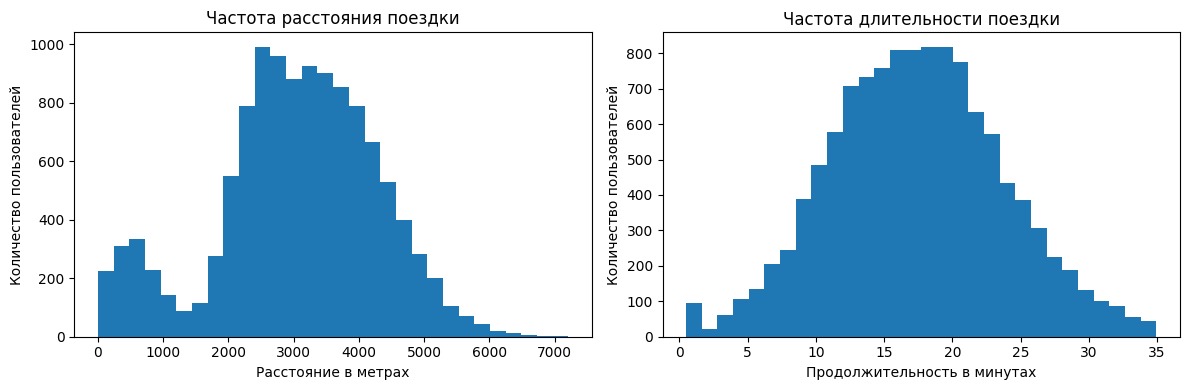

In [29]:
print("Пользователи без подписки")
rides_frequencies(unsubscribed)

Расстояние средней поездки схоже для обеих групп пользователей. Однако заметно, что пользователи без подписки чаще проезжают более короткое расстояние.

Касаемо времени пролдолжительности поездки, пользователи без подписки чаще заканчивают поездку на первой минуте. При этом среднее время поездки для обеих групп пользователей схожее. 

## Подсчёт выручки

In [30]:
user_stats = df.groupby("user_id").agg(
    total_distance = ("distance", "sum"),
    rides_count = ("distance", "count"),
    total_duration = ("duration", "sum")
).reset_index()
user_stats.head()

,user_id,total_distance,rides_count,total_duration
0,1,34070.182066,12,204.604909
1,2,33964.058614,11,197.644279
2,3,36907.597866,12,233.193513
3,4,44837.189916,14,288.563581
4,5,35556.949649,11,174.073932


In [31]:
free = subscriptions[subscriptions["subscription_type"] == "free"].iloc[0]
sub = subscriptions[subscriptions["subscription_type"] == "ultra"].iloc[0]

def calculate_revenue(row):
    if users[users["user_id"] == row["user_id"]].iloc[0]["subscription_type"] == "free":
        return int(free["minute_price"] * math.ceil(row["total_duration"]) + free["start_ride_price"] * row["rides_count"] + free["subscription_fee"])
    else:
        return int(sub["minute_price"] * math.ceil(row["total_duration"]) + sub["start_ride_price"] * row["rides_count"] + sub["subscription_fee"])

user_stats["revenue"] = user_stats.apply(calculate_revenue, axis=1)
user_stats.head()

,user_id,total_distance,rides_count,total_duration,revenue
0,1,34070.182066,12,204.604909,1429
1,2,33964.058614,11,197.644279,1387
2,3,36907.597866,12,233.193513,1603
3,4,44837.189916,14,288.563581,1933
4,5,35556.949649,11,174.073932,1249


Создадим два датафрейма со статистикой по подписанными и не подписанным пользователям.

In [32]:
sub_user_stats = user_stats[user_stats["user_id"].isin(subscribed["user_id"])]
free_user_stats = user_stats.loc[user_stats.index.difference(sub_user_stats.index)]

print(f"Подписанных пользователей: {sub_user_stats['user_id'].count()}", f"Пользователей без подписки: {free_user_stats['user_id'].count()}", sep="\n")

Подписанных пользователей: 699
Пользователей без подписки: 835


### Гипотеза о длительности поездки

Т.к. обе выборки относительно небольшого размера проведём проверку гипотезы, что пользователи с подпиской и без неё тратят в среднем одинаковое время на поездки для них целиком. Альтернативной гипотезой будем считать что пользователи с подпиской тратят на поездки больше времени. Установим уровень статистической значимости в 5%.

In [33]:
alpha = .05

results = st.ttest_ind(sub_user_stats["total_duration"], free_user_stats["total_duration"], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.0
Не получилось отвергнуть нулевую гипотезу


Делаем вывод, что пользователи с подпиской тратят не больше времени на поездки, чем с подпиской.

### Гипотеза о расстоянии поездки

Чтобы проверить, какое расстояние в среднем проезжают пользователи с подпиской, будем считать что пользователи проезжают 3130 метров нулевой гипотезой. Альтернативной гепотезой будем считать что пользователь проезжает меньше 3130 метров за поездку. Установим уровень статистической значимости в 5%.

In [34]:
alpha = .05
optimal_distance = 3130

results = st.ttest_1samp(sub_user_stats["total_distance"] / sub_user_stats["rides_count"], optimal_distance, alternative='less')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.07249587399491073
Не получилось отвергнуть нулевую гипотезу


Делаем вывод, что пользователи с подпиской проезжают в среднем не более 3130 метров.

### Гипотеза о выручке

Для начала подготовим два среза данных со средними значениями выручки по месяцам для двух групп пользователей.

In [35]:
subscribed["ride_cost"] = (subscribed["minute_price"] * np.ceil(subscribed["duration"]) + subscribed["start_ride_price"]).astype("int")
sub_month_revenue = subscribed.groupby("month_number")[["ride_cost"]].agg(lambda x: x.sum() + subscribed["subscription_fee"].iloc[0])

In [36]:
unsubscribed["ride_cost"] = (unsubscribed["minute_price"] * np.ceil(unsubscribed["duration"]) + unsubscribed["start_ride_price"]).astype("int")
free_month_revenue = subscribed.groupby("month_number")[["ride_cost"]].agg(lambda x: x.sum() + unsubscribed["subscription_fee"].iloc[0])

Сформулируем нулевую гепотизу как равенство месячных выручек для обеих групп пользователей. Альтернативная гепотиза предполагает что выручка от пользоватей с подпиской выше, чем от пользователей без подписки. Предположем также что разброс выручки одинаков для обоих групп пользователей. Установим уровень статистической значимости в 5%.

In [37]:
alpha = .05

results = st.ttest_ind(sub_month_revenue["ride_cost"], free_month_revenue["ride_cost"], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.45856494247758034
Не получилось отвергнуть нулевую гипотезу


Делаем вывод, что выручка не зависит от группы пользователей.

### Гепотеза об обращениях в техподдержку

Т.к. вы,орки зависимы между собой (пользователи одни и те же), я бы выбрал проверку гепотезы о равенстве среднего значения генеральной совокупности до и после изменения и метод ttest_rel.

## Распределения

### Промо акция

Т.к. у нас серия испытаний Бернулли, нужно брать биномиальное распределение для с.в. Подберём перебором такое количество экспериментов (выданных промокодов), при котором вероятность получить 100 подписчиков равна 5%.

In [43]:
subscription_prob = .1
plan_failure = .05
subscribers_count = 100

accuracy = math.inf
needed_promocodes_count = 0

for promocodes_count in range(100, 10000):
    difference = abs(plan_failure - st.binom.cdf(k = subscribers_count, n = promocodes_count, p = subscription_prob))
    if difference < accuracy:
        accuracy = difference
        needed_promocodes_count = promocodes_count

print(f"{needed_promocodes_count} промокодов нужно для выполнения плана.")



1172 промокодов нужно для выполнения плана.


### Уведомления

Проверим условия аппроксимации распределением Пуассона. Значение вероятности успеха нельзя считать малым т.к. оно 40%. Поэтому проверим условие применимости аппроксимации нормальным распределением.

In [49]:
notifications_count = 1_000_000
ctr = .4
engaged_users = 399_500

three_std = notifications_count * ctr - 3 * math.sqrt(notifications_count * ctr * (1 - ctr))

if three_std >= 0 and three_std <= notifications_count:
    print("Можно аппроксимировать нормальным распределением.")
else:
    print("Нельзя аппроксимировать нормальным распределением.")

Можно аппроксимировать нормальным распределением.


Построим график приближённого распределения.

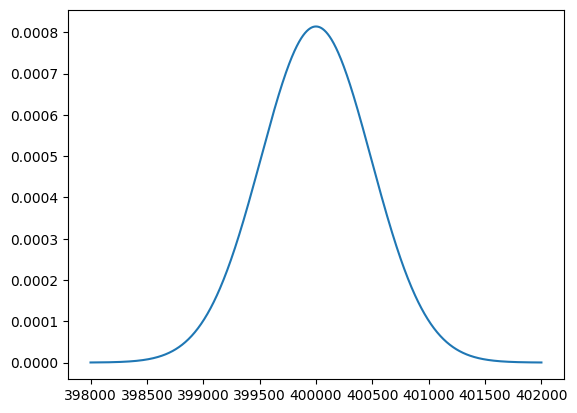

In [54]:
left = notifications_count * ctr - 2000
right = notifications_count * ctr + 2000

x = np.linspace(left, right, 1_000)

plt.plot(x, st.norm.pdf(x, notifications_count * ctr, math.sqrt(notifications_count * ctr * (1 - ctr))))

Посчитаем вероятность количества кликов меньшего чем 399_500.

In [57]:
prob = st.norm(notifications_count * ctr, math.sqrt(notifications_count * ctr * (1 - ctr))).cdf(engaged_users)

print(f"Вероятность что не более {engaged_users} пользователей откроют уведомление равна {prob * 100:.2f}%")

Вероятность что не более 399500 пользователей откроют уведомление равна 15.37%
